In [1]:
from mnist import MNIST
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# A.3

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [19]:
#actual function
def f(x):
    return 4*math.sin(math.pi*x)*math.cos(6*math.pi*x*x)

def f_poly(x,X,alpha,d):
    y=0
    for j in range(len(X)):
        y+= alpha[j]*(1+x*X[j])**d
    return y

def f_rbf(x,X,alpha,gamma):
    y=0
    for j in range(len(X)):
        y += alpha[j]*math.exp(-gamma*(x-X[j])**2)
    return y
    
#model
#kernel param determines which kernel to use
#k is the number of data points used for validation
#k=1 part(a), k=30 for part (d)
#d can either be degree or gamma, depending on kernel
def f_hat(X_train,X_val,alpha,d,k,kernel):
    prediction = np.zeros(k)
    if kernel == 'poly':
        for i in range(k):
            for j in range(len(X_train)):
                prediction[i] += alpha[j]*(1+X_val[i]*X_train[j])**d
    if kernel == 'rbf':
        for i in range(k):
            for j in range(len(X_train)):
                prediction[i] += alpha[j]*math.exp(-d*(X_val[i]-X_train[j])**2)
    return prediction

    
#solves polynomial and rbf kernel ridge regression
#returns alpha_hat = (K+ lam*I)^{-1}Y
#d can either be degree or gamma depending on if kernel
#is polynomial or rbf
def kerRR(X,Y,lam,d,kernel):
    n = len(X)
    K = np.zeros((n,n))
    for i in range(n): #initialize K
        for j in range(n):
            if kernel == 'poly':
                K[i,j]=(1+X[i]*X[j])**d
            if kernel == 'rbf':
                K[i,j]=math.exp(-d*(X[i]-X[j])**2)
    return np.linalg.inv(K + lam*np.eye(n)) @ Y

#performs cross validation on data
#k=num data points to leave out, eg k=1 does leave-one-out CV
#returns best hyperparameters lambda and d
def kerCrossVal(X,Y,k,kernel):
    n = len(X)
    num_validations = int(n/k)
    d_vals = [i+1 for i in range(25)]  #d's = [1,2,...,25]
    lam_vals = [1/(10**(5-i)) for i in range(25)] #lams = [10000,1000,...,1e-19]
    best_d = 0  #best hyperparameter d
    best_lam = 0  #best hyperparam lambda
    indices = np.arange(0,n)
    np.random.shuffle(indices)
    error_min = -1
    for d in d_vals:
            for lam in lam_vals:
                error = 0
                #iterate through validation batches and calculate error
                for i in range(num_validations):
                    to_delete = indices[i*k : (i+1)*k]
                    X2 = np.copy(X)
                    X2 = np.delete(X2,to_delete)  #create training X
                    Y2 = np.copy(Y)
                    Y2 = np.delete(Y2,to_delete)  #create training Y
                    Xtest = X[to_delete]   #create validation X
                    Ytest = Y[to_delete]   #create validation Y
                    alpha = kerRR(X2,Y2,lam,d,kernel)   #solve ridge reg
                    prediction = f_hat(X2,Xtest,alpha,d,k,kernel)  #model output
                    error+= (np.linalg.norm(Ytest-prediction)**2)/k
                if error_min == -1:
                    error_min = error
                if (error < error_min):
                    best_d = d
                    best_lam = lam
                    error_min = error
    return best_d, best_lam

In [4]:
#generate data
n = 300
X = np.random.uniform(0,1,n)
err = np.random.randn(n)
y_true = np.zeros(n)
for i in range(n):
    y_true[i] = f(X[i])
Y = y_true + err

In [20]:
#k=1 #leave one out CV
k=30 #10-fold CV
deg,lam_poly = kerCrossVal(X,Y,k,'poly')
gamma,lam_rbf = kerCrossVal(X,Y,k,'rbf')
print(deg,lam_poly)
print(gamma,lam_rbf)

25 1e-05
16 1e-05


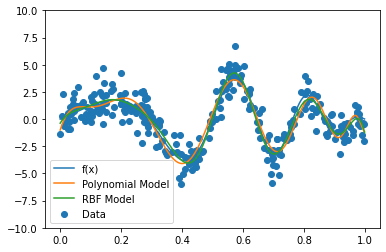

In [21]:
def f_poly(x,X,alpha,d):
    y=0
    for j in range(len(X)):
        y+= alpha[j]*(1+x*X[j])**d
    return y

def f_rbf(x,X,alpha,gamma):
    y=0
    for j in range(len(X)):
        y += alpha[j]*math.exp(-gamma*(x-X[j])**2)
    return y

mesh = np.arange(0,1,.001)

alpha_poly = kerRR(X,Y,lam_poly,deg,'poly')
alpha_rbf = kerRR(X,Y,lam_rbf,gamma,'rbf')

poly_model = [f_poly(mesh[j],X,alpha_poly,deg) for j in range(1000)]
rbf_model = [f_rbf(mesh[j],X,alpha_rbf,gamma) for j in range(1000)]

plt.plot(mesh,[f(mesh[j]) for j in range(1000)],label='f(x)')
plt.scatter(X,Y,label='Data')
plt.plot(mesh, poly_model,label='Polynomial Model')
plt.plot(mesh, rbf_model,label='RBF Model')
plt.ylim((-10,10))
plt.legend()

In [22]:
#generate samples for polynomial RR
alpha_params_poly = np.zeros((300,n))
Xsamples_poly = np.zeros((300,n))
Ysamples_poly = np.zeros((300,n))
for i in range(300):
    for j in range(n):
        k = np.random.randint(0,n)
        Xsamples_poly[i,j] = X[k]
        Ysamples_poly[i,j] = Y[k]
    alpha_params_poly[i,:] = kerRR(Xsamples_poly[i,:],Ysamples_poly[i,:],lam_poly,deg,'poly')
    
#generate samples for rbf RR
alpha_params_rbf = np.zeros((300,n))
Xsamples_rbf = np.zeros((300,n))
Ysamples_rbf = np.zeros((300,n))
for i in range(300):
    for j in range(n):
        k = np.random.randint(0,n)
        Xsamples_rbf[i,j] = X[k]
        Ysamples_rbf[i,j] = Y[k]
    alpha_params_rbf[i,:] = kerRR(Xsamples_rbf[i,:],Ysamples_rbf[i,:],lam_rbf,gamma,'rbf')

In [23]:
#calculate 5th and 95th percentiles
p5_poly = np.zeros(1000)
p95_poly = np.zeros(1000)
p5_rbf = np.zeros(1000)
p95_rbf = np.zeros(1000)

for i in range(1000):
    x_i = np.array([mesh[i]]) 
    predictions_poly = np.zeros(300)
    predictions_rbf = np.zeros(300)
    
    for j in range(300):
        predictions_poly[j] = f_hat(Xsamples_poly[j,:],x_i,alpha_params_poly[j,:],deg,1,'poly')
        predictions_rbf[j] = f_hat(Xsamples_rbf[j,:],x_i,alpha_params_rbf[j,:],gamma,1,'rbf')
    
    predictions_poly = np.sort(predictions_poly)
    predictions_rbf = np.sort(predictions_rbf)
    
    p5_poly[i] = predictions_poly[14]
    p95_poly[i] = predictions_poly[284]
    p5_rbf[i] = predictions_rbf[14]
    p95_rbf[i] = predictions_rbf[284]

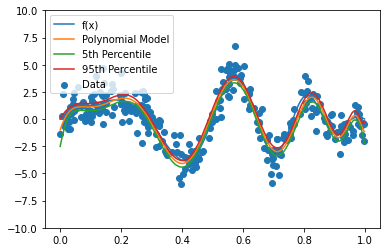

In [24]:
#plot polynomial RR
plt.plot(mesh,[f(mesh[j]) for j in range(1000)],label='f(x)')
plt.scatter(X,Y,label='Data')
plt.plot(mesh, poly_model,label='Polynomial Model')
plt.plot(mesh, p5_poly, label='5th Percentile')
plt.plot(mesh, p95_poly, label='95th Percentile')
plt.ylim((-10,10))
plt.legend()

In [1]:
#plot rbf RR
plt.plot(mesh,[f(mesh[j]) for j in range(1000)],label='f(x)')
plt.scatter(X,Y,label='Data')
plt.plot(mesh, rbf_model,label='RBF Model')
plt.plot(mesh, p5_rbf, label='5th Percentile')
plt.plot(mesh, p95_rbf, label='95th Percentile')
plt.ylim((-10,10))
plt.legend()

NameError: name 'plt' is not defined

In [16]:
m=1000
X=np.random.uniform(0,1,m)
Ytrue = np.zeros(m)
for i in range(m):
    Ytrue[i] = f(X[i])
Y = np.zeros(m)
errors = np.random.randn(m)
Y = Ytrue + errors

In [20]:
alpha_poly = kerRR(X,Y,1e-5,25,'poly')
alpha_rbf = kerRR(X,Y,1e-5,16,'rbf')

expected = np.zeros(300)
for i in range(300):
    Xsamples = list()
    Ysamples = list()
    pred_rbf = np.zeros(m)
    pred_poly = np.zeros(m)
    for j in range(m):
        k = np.random.randint(0,n)
        Xsamples.append(X[k])
        Ysamples.append(Y[k])
        pred_rbf[j] = f_rbf(X[k],X,alpha_rbf,16)
        pred_poly[j] = f_poly(X[k],X,alpha_poly,25)
    expected[i] = ((pred_poly-Ysamples).dot(pred_poly-Ysamples) - (pred_rbf-Ysamples).dot(pred_rbf-Ysamples))/m
expected = np.sort(expected)
expected[14], expected[284]

(0.027591983282914498, 0.08888975202271376)

In [ ]:
# A.4

In [3]:
def load_dataset():
    mndata = MNIST('/Users/joseph/Courses/cse546/hw2/mnist')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return [X_train, labels_train, X_test, labels_test]

[X_train, labels_train, X_test, labels_test] = load_dataset()
X_train = torch.from_numpy(X_train).float()
labels_train = torch.from_numpy(labels_train)
X_test = torch.from_numpy(X_test).float()
labels_test = torch.from_numpy(labels_test)

In [4]:
n, k, d, h = 60000, 10, 784, 64
n2 = 10000
step_size = .01
losses=[]

W0 = torch.empty(h,d,requires_grad=True)
W1 = torch.empty(k,h,requires_grad=True)
b0 = torch.empty(h,1,requires_grad=True)
b1 = torch.empty(k,1,requires_grad=True)

nn.init.uniform_(W0,-1/np.sqrt(h),1/np.sqrt(h))
nn.init.uniform_(b0,-1/np.sqrt(h),1/np.sqrt(h))
nn.init.uniform_(W1,-1/np.sqrt(k),1/np.sqrt(k))
nn.init.uniform_(b1,-1/np.sqrt(k),1/np.sqrt(k))

optimizer = torch.optim.Adam([W0,b0,W1,b1], lr=step_size)

def model(X,W0,b0,W1,b1):
    temp = W0 @ torch.transpose(X,0,1)
    for i in range(n):
        temp[:,i] = temp[:,i] + torch.transpose(b0,0,1)
    temp = W1 @ nn.functional.relu(temp)
    for i in range(n):
        temp[:,i] = temp[:,i] + torch.transpose(b1,0,1)
    return temp

In [ ]:
for i in range(10):
    y_hat = torch.transpose(model(X_train,W0,b0,W1,b1),0,1)
    loss = nn.functional.cross_entropy(y_hat,labels_train)
    losses.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    print(loss)

tensor(2.3917, grad_fn=<NllLossBackward>)
tensor(1.7633, grad_fn=<NllLossBackward>)


In [47]:
X_train.shape

torch.Size([60000, 784])

In [ ]:
# A.5

In [6]:
import torch
import torchvision 
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

In [20]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean = [.485,.456,.406], std=[.229,.224,.225])]
)

train_data = torchvision.datasets.CIFAR10(root='cifar-10-batches.py', train=True, download=True, transform=transform)
train, val = random_split(train_data,[45000,5000])

trainloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=16, shuffle=True)

test_data = torchvision.datasets.CIFAR10(root='cifar-10-batches.py', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar-10-batches.py
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [22]:
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.classifier[6] = nn.Linear(4096,10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

losses_train=[]
losses_val=[]

In [25]:
epochs = 100
for i in range(epochs):
    for images, labels in trainloader:
        images = images.cuda()
        labels = labels.cuda()
        y_hat = model(images)
    
        loss_train = nn.functional.cross_entropy(y_hat,labels)

        losses_train.append(loss_train.item())
    
        optimizer.zero_grad()
        loss_train.backward()
    
        optimizer.step()
    print(f'Epoch {epoch+1} training loss: {J.item()}')
    
    for images, labels in valloader:
        images = images.cuda()
        labels = labels.cuda()
        with torch.no_grad():
            y_hat = model(images)
            
        loss_val = nn.functional.cross_entropy(y_hat,labels)
        losses_val.append(loss_val.item())
    print(f'Epoch {epoch+1} validation loss: {J.item()}')

KeyboardInterrupt: 